In [1]:
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms
import torch.utils.data
from torchvision import models
import torch.nn
import numpy as np
import os
import time
import graphviz
from matplotlib import pyplot as plot
import math

In [2]:
dir_name = os.getcwd()


In [3]:
image_size = 32
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

In [4]:
train_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomCrop(image_size, padding=4, padding_mode='reflect'),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(means, stds,inplace=True)
    ]
)

test_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(means, stds,inplace=True)
    ]
)

In [5]:
train_dataset = torchvision.datasets.CIFAR10(
    root = dir_name, train = True, download = True,
    transform = train_transforms
)
test_dataset = torchvision.datasets.CIFAR10(
    root = dir_name, train = False, download = True,
    transform = test_transforms
)

print('Number of train samples: {}, shape: {}'.format(len(train_dataset), train_dataset[0][0].shape))
print('Number of test samples: {}, shape: {}'.format(len(test_dataset), test_dataset[0][0].shape))
print(type(train_dataset), type(train_dataset[0][0]), type(train_dataset[0][1]))
print(train_dataset[0][1])

100%|██████████| 170498071/170498071 [00:02<00:00, 77507647.16it/s]


Extracting /content/cifar-10-python.tar.gz to /content
Files already downloaded and verified
Number of train samples: 50000, shape: torch.Size([3, 32, 32])
Number of test samples: 10000, shape: torch.Size([3, 32, 32])
<class 'torchvision.datasets.cifar.CIFAR10'> <class 'torch.Tensor'> <class 'int'>
6


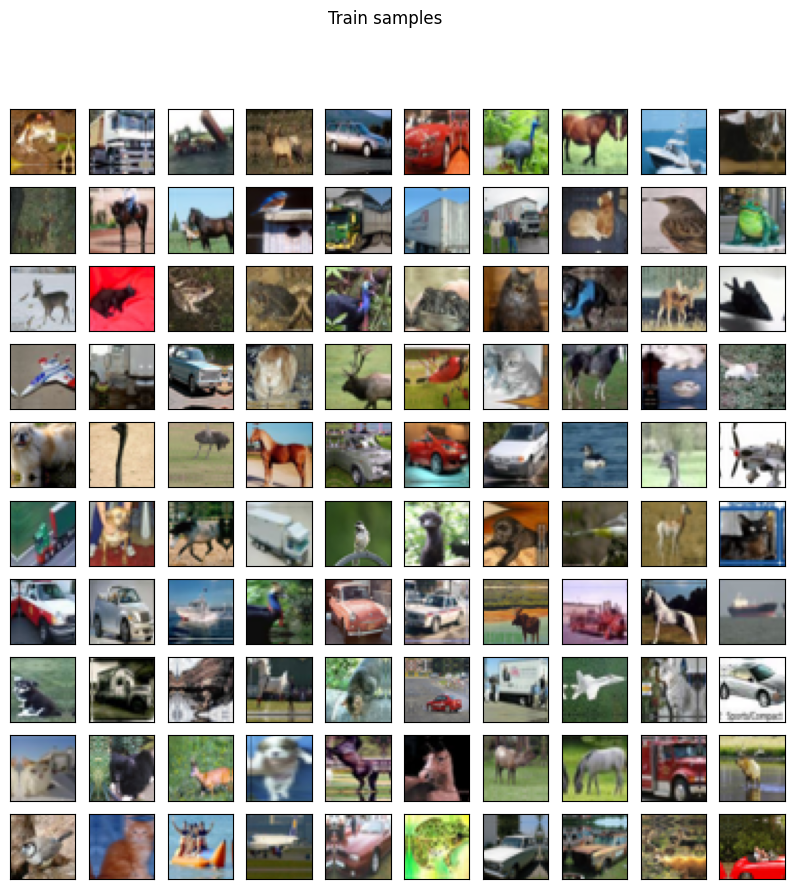

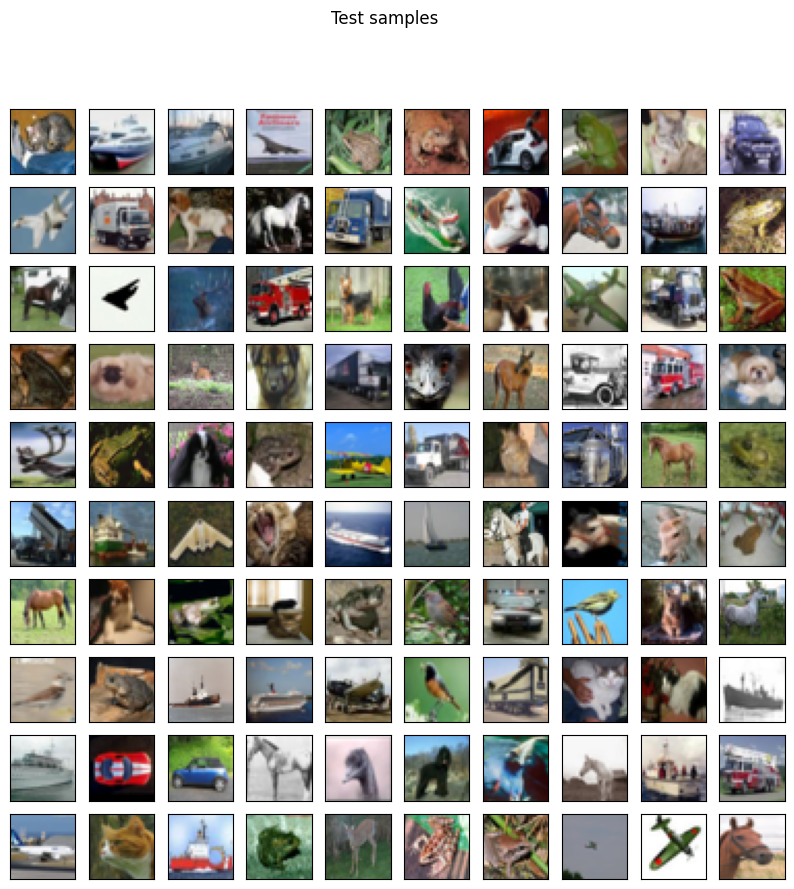

In [6]:
def denormal(image, means, stds):
    means = torch.tensor(means).reshape(3, 1, 1)
    stds = torch.tensor(stds).reshape(3, 1, 1)
    return image * stds + means

def show_images(images, title):
    num_showed_imgs_x = 10
    num_showed_imgs_y = 10

    figsize = (10, 10)
    fig, axes = plot.subplots(num_showed_imgs_y, num_showed_imgs_x, figsize = figsize)
    fig.suptitle(title)
    plot.setp(plot.gcf().get_axes(), xticks = [], yticks = [])
    for i, ax in enumerate(axes.flat):
        img = denormal(images[i][0], means, stds).numpy().transpose(1, 2, 0)
        ax.imshow((img * 255).astype('uint8'))

show_images(train_dataset, 'Train samples')
show_images(test_dataset, 'Test samples')

In [7]:
accuracys={}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:

densnet_model_1 = models.densenet121(pretrained=True).to(device)# download the pre-trained ImageNet weights

densnet_model_1.eval()

classes = 10

densnet_model_1.classifier = torch.nn.Linear(densnet_model_1.classifier.in_features, classes).to(device)

# puts our model into evaluation mode, instructing PyTorch to handle
# special layers, such as dropout and batch normalization, different
# from how it would otherwise handle them during training.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 139MB/s]


In [9]:
def get_accuracy(data_loader, model, device):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            tp += (predicted == labels).sum()
    return tp / n


def train(num_epochs, data_loader, model):
  loss_function = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
  start_time = time.time()
  for epoch in range(num_epochs):
    start_epoch = time.time()

    for i, (images, labels) in enumerate(data_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

    time_epoch = time.time() - start_epoch
    print('Epoch[{}]: Train accuracy = {:.4f}, Time epoch = {:.4f}'.
          format(epoch,get_accuracy(data_loader, model, device),time_epoch))

  total_time = time.time() - start_time
  print('Total time {}'.format(total_time))

def test(data_loader, model, name_model):
  accuracy = get_accuracy(data_loader, model, device)
  accuracys[name_model] = accuracy.item()
  print('Test accuracy = {}'.format(get_accuracy(data_loader, model, device)))

In [10]:
learning_rate = 0.001
num_epochs = 10
batch_sizes = 256

train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size = batch_sizes, shuffle = True
)
test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size = batch_sizes, shuffle = False
)

In [11]:
train(num_epochs, train_data_loader, densnet_model_1)


Epoch[0]: Train accuracy = 0.6530, Time epoch = 56.3261
Epoch[1]: Train accuracy = 0.7372, Time epoch = 48.9280
Epoch[2]: Train accuracy = 0.7874, Time epoch = 49.4100
Epoch[3]: Train accuracy = 0.8008, Time epoch = 49.6863
Epoch[4]: Train accuracy = 0.8260, Time epoch = 49.5454
Epoch[5]: Train accuracy = 0.8434, Time epoch = 48.9317
Epoch[6]: Train accuracy = 0.8418, Time epoch = 49.4806
Epoch[7]: Train accuracy = 0.8483, Time epoch = 49.3740
Epoch[8]: Train accuracy = 0.8497, Time epoch = 49.6227
Epoch[9]: Train accuracy = 0.8479, Time epoch = 48.7342
Total time 867.4713191986084


In [12]:
test(test_data_loader, densnet_model_1, "denseNet")

Test accuracy = 0.8278999924659729


In [13]:
densnet_model_2 = models.densenet121(pretrained=True).to(device)

classes = 10

input_layers = densnet_model_2.classifier.in_features

densnet_model_2.classifier = torch.nn.Sequential(
        torch.nn.Linear(input_layers, input_layers//2),
        torch.nn.ReLU(),
        torch.nn.Linear(input_layers//2, 10),
        ).to(device)

In [14]:
train(num_epochs, train_data_loader, densnet_model_2)


Epoch[0]: Train accuracy = 0.8020, Time epoch = 51.6817
Epoch[1]: Train accuracy = 0.8426, Time epoch = 46.5015
Epoch[2]: Train accuracy = 0.8601, Time epoch = 45.9583
Epoch[3]: Train accuracy = 0.8763, Time epoch = 46.5837
Epoch[4]: Train accuracy = 0.8870, Time epoch = 47.2006
Epoch[5]: Train accuracy = 0.8953, Time epoch = 48.7376
Epoch[6]: Train accuracy = 0.8983, Time epoch = 47.3237
Epoch[7]: Train accuracy = 0.8990, Time epoch = 47.2075
Epoch[8]: Train accuracy = 0.9071, Time epoch = 47.1675
Epoch[9]: Train accuracy = 0.9222, Time epoch = 47.5523
Total time 850.8633897304535


In [15]:
test(test_data_loader, densnet_model_2, "denseNet_2")

Test accuracy = 0.8750999569892883


In [16]:
print(accuracys)

{'denseNet': 0.8278999924659729, 'denseNet_2': 0.8750999569892883}


In [17]:
shufflenet_model_1 = models.shufflenet_v2_x1_0(pretrained=True).to(device)# download the pre-trained ImageNet weights

shufflenet_model_1.eval()

classes = 10

shufflenet_model_1.fc = torch.nn.Linear(shufflenet_model_1.fc.in_features, classes).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth
100%|██████████| 8.79M/8.79M [00:00<00:00, 71.3MB/s]


In [18]:
train(num_epochs, train_data_loader, shufflenet_model_1)
test(test_data_loader, shufflenet_model_1, "shufflenet")

Epoch[0]: Train accuracy = 0.6821, Time epoch = 37.0540
Epoch[1]: Train accuracy = 0.6989, Time epoch = 37.6706
Epoch[2]: Train accuracy = 0.7517, Time epoch = 37.3976
Epoch[3]: Train accuracy = 0.7681, Time epoch = 35.8936
Epoch[4]: Train accuracy = 0.7659, Time epoch = 35.9834
Epoch[5]: Train accuracy = 0.7803, Time epoch = 36.3296
Epoch[6]: Train accuracy = 0.7798, Time epoch = 35.7654
Epoch[7]: Train accuracy = 0.8015, Time epoch = 35.1547
Epoch[8]: Train accuracy = 0.7989, Time epoch = 35.5814
Epoch[9]: Train accuracy = 0.8009, Time epoch = 34.8819
Total time 688.3619465827942
Test accuracy = 0.7894999980926514


In [19]:
shufflenet_model_2 = models.shufflenet_v2_x1_0(pretrained=True).to(device)

classes = 10

shufflenet_model_2.eval()

input_layers = shufflenet_model_2.fc.in_features

shufflenet_model_2.fc = torch.nn.Sequential(
        torch.nn.Linear(input_layers, input_layers//2),
        torch.nn.ReLU(),
        torch.nn.Linear(input_layers//2, 10),
        ).to(device)

In [20]:
train(num_epochs, train_data_loader, shufflenet_model_2)
test(test_data_loader, shufflenet_model_2, "shufflenet_2")

Epoch[0]: Train accuracy = 0.6885, Time epoch = 35.6270
Epoch[1]: Train accuracy = 0.7084, Time epoch = 35.9220
Epoch[2]: Train accuracy = 0.7437, Time epoch = 35.8565
Epoch[3]: Train accuracy = 0.7428, Time epoch = 35.0354
Epoch[4]: Train accuracy = 0.7756, Time epoch = 34.4575
Epoch[5]: Train accuracy = 0.7842, Time epoch = 34.2138
Epoch[6]: Train accuracy = 0.7885, Time epoch = 34.1564
Epoch[7]: Train accuracy = 0.7917, Time epoch = 34.8754
Epoch[8]: Train accuracy = 0.7897, Time epoch = 35.5255
Epoch[9]: Train accuracy = 0.8000, Time epoch = 35.3023
Total time 668.9480621814728
Test accuracy = 0.788100004196167


In [21]:
googlnet_model_1 = models.googlenet(pretrained=True).to(device)# download the pre-trained ImageNet weights

googlnet_model_1.eval()

classes = 10

googlnet_model_1.fc = torch.nn.Linear(googlnet_model_1.fc.in_features, classes).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 153MB/s]


In [22]:
train(num_epochs, train_data_loader, googlnet_model_1)
test(test_data_loader, googlnet_model_1, "googlNet")

Epoch[0]: Train accuracy = 0.5754, Time epoch = 35.2774
Epoch[1]: Train accuracy = 0.7195, Time epoch = 35.1312
Epoch[2]: Train accuracy = 0.7571, Time epoch = 35.1438
Epoch[3]: Train accuracy = 0.7837, Time epoch = 35.2631
Epoch[4]: Train accuracy = 0.7961, Time epoch = 35.4807
Epoch[5]: Train accuracy = 0.8089, Time epoch = 35.2232
Epoch[6]: Train accuracy = 0.8180, Time epoch = 35.4853
Epoch[7]: Train accuracy = 0.8327, Time epoch = 35.0914
Epoch[8]: Train accuracy = 0.8331, Time epoch = 35.4579
Epoch[9]: Train accuracy = 0.8380, Time epoch = 35.2745
Total time 681.6014273166656
Test accuracy = 0.8198999762535095


In [23]:
googlnet_model_2 = models.googlenet(pretrained=True).to(device)

classes = 10

googlnet_model_2.eval()

input_layers = googlnet_model_2.fc.in_features

googlnet_model_2.fc = torch.nn.Sequential(
        torch.nn.Linear(input_layers, input_layers//2),
        torch.nn.ReLU(),
        torch.nn.Linear(input_layers//2, 10),
        ).to(device)

In [24]:
train(num_epochs, train_data_loader, googlnet_model_2)
test(test_data_loader, googlnet_model_2, "googlNet_2")

Epoch[0]: Train accuracy = 0.4694, Time epoch = 36.6119
Epoch[1]: Train accuracy = 0.6197, Time epoch = 36.5582
Epoch[2]: Train accuracy = 0.7330, Time epoch = 36.6343
Epoch[3]: Train accuracy = 0.7590, Time epoch = 36.7422
Epoch[4]: Train accuracy = 0.7840, Time epoch = 37.0462
Epoch[5]: Train accuracy = 0.7816, Time epoch = 36.5671
Epoch[6]: Train accuracy = 0.8168, Time epoch = 36.2511
Epoch[7]: Train accuracy = 0.8117, Time epoch = 36.3748
Epoch[8]: Train accuracy = 0.8087, Time epoch = 36.1628
Epoch[9]: Train accuracy = 0.8386, Time epoch = 36.4221
Total time 685.2801992893219
Test accuracy = 0.820099949836731


In [25]:
resnet_model_1 = models.resnet18(pretrained=True).to(device)# download the pre-trained ImageNet weights

resnet_model_1.eval()

classes = 10

resnet_model_1.fc = torch.nn.Linear(resnet_model_1.fc.in_features, classes).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 144MB/s]


In [26]:
torch.cuda.empty_cache()
import gc
gc.collect()

9

In [27]:
train(num_epochs, train_data_loader, resnet_model_1)
test(test_data_loader, resnet_model_1, "resNet")

Epoch[0]: Train accuracy = 0.6184, Time epoch = 32.4546
Epoch[1]: Train accuracy = 0.6961, Time epoch = 32.5508
Epoch[2]: Train accuracy = 0.7728, Time epoch = 32.3972
Epoch[3]: Train accuracy = 0.7953, Time epoch = 31.9936
Epoch[4]: Train accuracy = 0.8121, Time epoch = 32.8658
Epoch[5]: Train accuracy = 0.8186, Time epoch = 32.0403
Epoch[6]: Train accuracy = 0.8212, Time epoch = 32.2073
Epoch[7]: Train accuracy = 0.8357, Time epoch = 33.3092
Epoch[8]: Train accuracy = 0.8505, Time epoch = 32.1075
Epoch[9]: Train accuracy = 0.8530, Time epoch = 32.2820
Total time 635.0402121543884
Test accuracy = 0.830299973487854


In [28]:
resnet_model_2 = models.resnet18(pretrained=True).to(device)

classes = 10

resnet_model_2.eval()

input_layers = resnet_model_2.fc.in_features

resnet_model_2.fc = torch.nn.Sequential(
        torch.nn.Linear(input_layers, input_layers//2),
        torch.nn.ReLU(),
        torch.nn.Linear(input_layers//2, 10),
        ).to(device)

In [29]:
train(num_epochs, train_data_loader, resnet_model_2)
test(test_data_loader, resnet_model_1, "resNet_2")

Epoch[0]: Train accuracy = 0.5102, Time epoch = 32.6578
Epoch[1]: Train accuracy = 0.6664, Time epoch = 33.6848
Epoch[2]: Train accuracy = 0.6959, Time epoch = 32.5235
Epoch[3]: Train accuracy = 0.7857, Time epoch = 32.1296
Epoch[4]: Train accuracy = 0.7936, Time epoch = 33.0466
Epoch[5]: Train accuracy = 0.8028, Time epoch = 33.3202
Epoch[6]: Train accuracy = 0.7827, Time epoch = 31.8205
Epoch[7]: Train accuracy = 0.8191, Time epoch = 33.3989
Epoch[8]: Train accuracy = 0.8278, Time epoch = 32.9269
Epoch[9]: Train accuracy = 0.8422, Time epoch = 32.7971
Total time 641.0098941326141
Test accuracy = 0.830299973487854


In [30]:
# my model class BottleneckLayer(torch.nn.Module):
class BottleneckLayer(torch.nn.Module):
    def __init__(self, input, growth_rate):
      super(BottleneckLayer, self).__init__()
      self.bn1 = torch.nn.BatchNorm2d(input)
      self.conv1 = torch.nn.Conv2d(input, 4*growth_rate, kernel_size=1,
                              bias=False)
      self.bn2 = torch.nn.BatchNorm2d(4*growth_rate)
      self.conv2 = torch.nn.Conv2d(4*growth_rate, growth_rate, kernel_size=3,
                              padding=1, bias=False)
      self.relu = torch.nn.ReLU()

    def forward(self, x):
      out = self.bn1(x)
      out = self.relu(out)
      out = self.conv1(out)
      out = self.bn2(out)
      out = self.relu(out)
      out = self.conv2(out)
      out = torch.cat([out,x], 1)
      return out


class TransitionLayer(torch.nn.Module):
    def __init__(self, input, output):
      super(TransitionLayer, self).__init__()
      self.bn = torch.nn.BatchNorm2d(input)
      self.conv = torch.nn.Conv2d(input, output, kernel_size=1, bias=False)

    def forward(self, x):
      out = self.bn(x)
      out = torch.nn.ReLU()(out)
      out = self.conv(out)
      out = torch.nn.functional.avg_pool2d(out, 2)
      return out

nblocks = [6,12,24,16]
class DenseNet(torch.nn.Module):
    def __init__(self, growth_rate=12, reduction=0.5, num_classes=10):
        super(DenseNet, self).__init__()

        self.growth_rate = growth_rate

        self.conv1 = torch.nn.Conv2d(3, 2 * self.growth_rate, kernel_size=3, padding=1, bias=False)
        next_input = 2 * self.growth_rate
        self.dense1 = self.dense_layers(next_input, nblocks[0])

        next_input += nblocks[0] * self.growth_rate
        next_out = math.floor(next_input * reduction)

        self.trans1 = TransitionLayer(next_input, next_out)
        next_input = next_out
        self.dense2 = self.dense_layers(next_input, nblocks[1])

        next_input += nblocks[1] * self.growth_rate
        next_out = math.floor(next_input * reduction)

        self.trans2 = TransitionLayer(next_input, next_out)
        next_input = next_out
        self.dense3 = self.dense_layers(next_input, nblocks[2])

        next_input += nblocks[2] * self.growth_rate
        out_planes = math.floor(next_input * reduction)

        self.trans3 = TransitionLayer(next_input, next_out)
        next_input = next_out
        self.dense4 = self.dense_layers(next_input, nblocks[3])

        next_input += nblocks[3] * self.growth_rate

        self.bn = torch.nn.BatchNorm2d(next_input)
        self.linear = torch.nn.Linear(next_input, num_classes)

    def dense_layers(self, input, nblock):
        layers = []
        for i in range(nblock):
            layers.append(BottleneckLayer(input, self.growth_rate))
            input += self.growth_rate
        return torch.nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.dense1(out)
        out = self.trans1(out)
        out = self.dense2(out)
        out = self.trans2(out)
        out = self.dense3(out)
        out = self.trans3(out)
        out = self.dense4(out)
        out = self.bn(out)
        out = torch.nn.ReLU()(out)
        out = torch.nn.functional.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [33]:
cnn_model = DenseNet().to(device)

In [34]:
train(num_epochs, train_data_loader, cnn_model)
test(test_data_loader, cnn_model, "MyModel")

Epoch[0]: Train accuracy = 0.6505, Time epoch = 53.8311
Epoch[1]: Train accuracy = 0.7308, Time epoch = 54.4393
Epoch[2]: Train accuracy = 0.7834, Time epoch = 53.4889
Epoch[3]: Train accuracy = 0.8182, Time epoch = 53.9705
Epoch[4]: Train accuracy = 0.8491, Time epoch = 53.6991
Epoch[5]: Train accuracy = 0.8557, Time epoch = 54.0810
Epoch[6]: Train accuracy = 0.8729, Time epoch = 53.8617
Epoch[7]: Train accuracy = 0.8808, Time epoch = 55.5988
Epoch[8]: Train accuracy = 0.8890, Time epoch = 54.6480
Epoch[9]: Train accuracy = 0.8981, Time epoch = 54.2701
Total time 917.6869928836823
Test accuracy = 0.8720999956130981


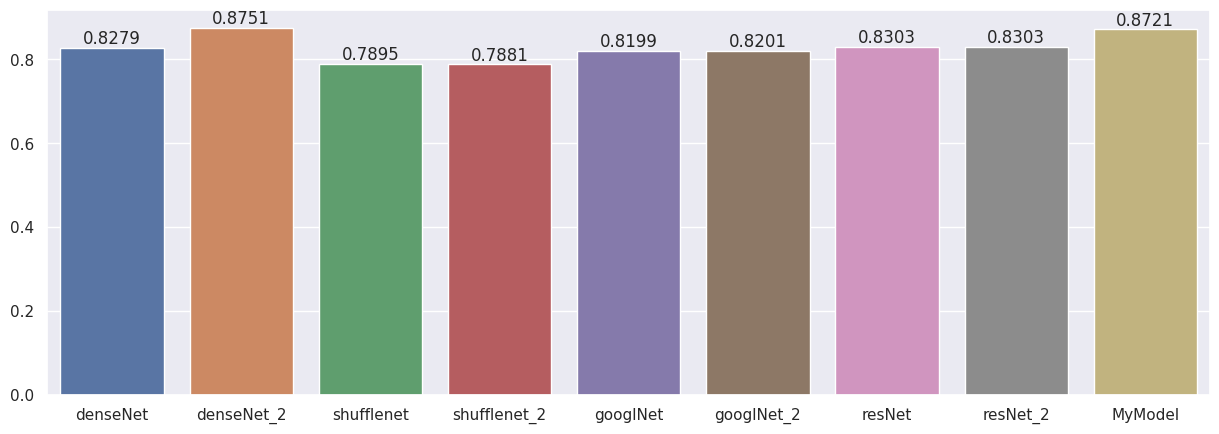

In [35]:
import seaborn

seaborn.set(rc={'figure.figsize': (15, 5)})

ax = seaborn.barplot(x=list(accuracys.keys()), y=list(accuracys.values()))

for i in ax.containers:
    ax.bar_label(i,)